# Bonus Challenge: Spiral Data Classification

Now that you completed Challenge 2, you know you can use the Tensorflow Playground to experiment the hyperparameters of your deep learning model. If you are brave enough to take on this challenge, we present you the spiral data generated by codes and you will replicate your model built visually in the Tensorflow Playground with Python codes.

Below are the codes to generate the spiral dataset. Read the remarks and execute the codes.

In [3]:
from math import hypot, cos, sin
import numpy as np
import pandas as pd

"""
A function to generate X/Y data points that will form a spiral.
"""
def spiral(radius, step, resolution=.1, angle=0.0, start=0.0):
    dist = start
    coords=[]
    while dist*hypot(cos(angle),sin(angle))<radius:
        cord=[]
        cord.append(dist*cos(angle))
        cord.append(dist*sin(angle))
        coords.append(cord)
        dist+=step
        angle+=resolution
    return coords

In [4]:
# Generate two sets of spiral data points with opposite angles
data_1 = np.array(spiral(1000, 5, angle=0))
data_2 = np.array(spiral(1000, 5, angle=180))

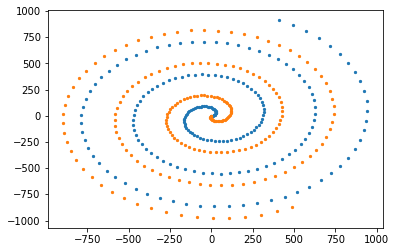

In [5]:
# Plot the two datasets to visualize the spirals

import matplotlib.pyplot as plt

a, b = data_1.T
plt.scatter(a, b, s=5)

aa, bb = data_2.T
plt.scatter(aa, bb, s=5)

plt.show()

In [6]:
# Combine the two spiral datasets into one

df1 = pd.DataFrame(data=data_1, columns=["X", "Y"])
df1["CLASS"] = 0

df2 = pd.DataFrame(data=data_2, columns=["X", "Y"])
df2["CLASS"] = 1

df = df1.append(df2)
df['CLASS'].value_counts()

0    201
1    201
Name: CLASS, dtype: int64

In [7]:
df

,X,Y,CLASS
0,0.000000,0.000000,0
1,4.975021,0.499167,0
2,9.800666,1.986693,0
3,14.330047,4.432803,0
4,18.421220,7.788367,0
...,...,...,...
196,106.478547,-974.198296,1
197,204.240898,-963.592578,1
198,300.939178,-943.151955,1
199,395.581665,-912.984198,1


In [8]:
x = df[['X','Y']]
y = df['CLASS']

In [125]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler 

ros = RandomOverSampler(random_state=42, sampling_strategy='all')

x_over, y_over = ros.fit_resample(x, y)

In [126]:
print(x_over.shape, y_over.shape)

(402, 2) (402,)


In [9]:
x_sq = x.pow(2)

In [10]:
x_y = x['X']*x['Y']

In [11]:
x_sin = np.sin(x)

In [12]:
x_new = pd.concat([x, x_sq, x_y, x_sin], axis=1)
x_new.columns = ['x1','x2','x12','x22','xy','x1sin','x2sin']
x_new.head()

,x1,x2,x12,x22,xy,x1sin,x2sin
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.975021,0.499167,24.750832,0.249168,2.483367,-0.965710,0.478694
2,9.800666,1.986693,96.053050,3.946950,19.470917,-0.367099,0.914754
3,14.330047,4.432803,205.350257,19.649743,63.522278,0.981456,-0.961170
4,18.421220,7.788367,339.341342,60.658658,143.471218,-0.415358,0.997848


In [13]:
# Normalize the input data.

#Power Transformer
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

x_tr = PowerTransformer().fit_transform(x_new)
x_tr = pd.DataFrame(x_tr, columns = x_new.columns)
    
#MinMaxScaler
x_mm = MinMaxScaler().fit_transform(x_tr)
x_mm = pd.DataFrame(x_mm, columns=x_new.columns) #convert np.array to pd.DataFrame

In [23]:
# Split the training and test data.
from sklearn.model_selection import train_test_split

np.random.seed(10)      #fix the random number generator, useful if you are including different columns
x_train, x_test, y_train, y_test = train_test_split(x_mm,y, test_size=0.5, random_state=42)

x_tr, x_te, y_tr, y_te= train_test_split(x,y, test_size=0.5, random_state=42)

Now, build a neural network with Tensorflow to classify `df`. See how low data loss and how high accuracy can you achieve!

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf # Library to construct neural newtorks. Low level library
from tensorflow import keras # High level library to handle tensorflow.
from tensorflow.keras.layers import Flatten, Dense, Dropout # Types of layers to use in our neural network.
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint 

In [116]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1] #'acc'
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [24]:
from sklearn.metrics import cohen_kappa_score, classification_report 

def model_performance_class(y_train, y_pred_train):#, y_test, y_pred_test):

    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
  #  print("==================================")
   # print("Results obtained for the TEST SET")
    #print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    #print(classification_report(y_test, y_pred_test))

In [142]:
from matplotlib.colors import ListedColormap

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = np.min(x)[0] - 0.1, np.max(x)[0] + 0.1
    y_min, y_max = np.min(x)[1] - 0.1, np.max(x)[1] + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00'])

    Z = np.round(model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0)) #round - class
    Z = Z[:,0].reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    y_color = [0 if x==1 else 1 for x in y]
    plt.scatter(x['X'], x['Y'], c=y_color, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

13/13 [==============================] - 0s 2ms/step
Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.95
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       201
           1       0.96      0.99      0.98       201

    accuracy                           0.98       402
   macro avg       0.98      0.98      0.98       402
weighted avg       0.98      0.98      0.98       402



<Figure size 576x432 with 0 Axes>

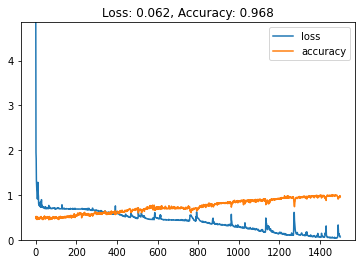

In [156]:
#early_stopping = EarlyStopping(patience=5) 
from keras.utils.np_utils import to_categorical

model = keras.Sequential()
#hidden layers
model.add(Dense(units = 256, activation='relu', input_shape=(2,) ))
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 32, activation='relu'))
model.add(Dense(units = 16, activation='relu'))
#model.add(Dense(units = 8, activation='relu'))
model.add(Dense(units = 2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

y_cat = to_categorical(y_over)
history = model.fit(
    x_over, y_cat, 
    epochs=1500, 
    batch_size=32, verbose=0)

plot_loss_accuracy(history)

y_pred_tr = np.argmax(model.predict(x_over), axis=1).reshape(-1,1)
model_performance_class(y_over, y_pred_tr)#, y_test, y_pred_te)

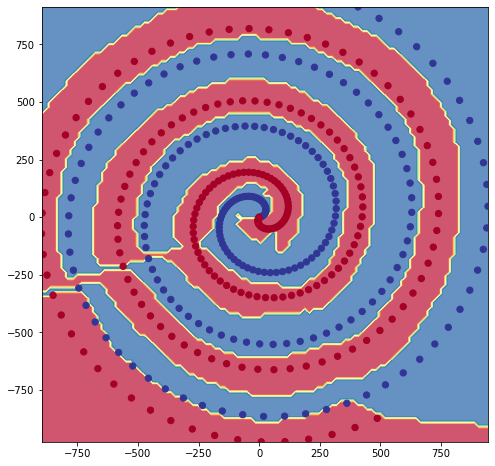

In [157]:
plot_multiclass_decision_boundary(model, x, y)